# FAKE NEWS CLASSIFICATION

## LIBRARIES

In [1]:
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import string
import time
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import WhitespaceTokenizer
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.utils import shuffle
from textblob import TextBlob
from xgboost import XGBClassifier
%matplotlib inline


## DATA PREPERATION

In [2]:
# Read CSV Dataset Files

fakedf = pd.read_csv('./dataset/Fake.csv')
truedf = pd.read_csv('./dataset/True.csv')

# Create 'target' for fake and real news

fakedf['target'] = 'fake'
truedf['target'] = 'true'

# Concatenate both DataFrames into a single dataset containing both real and fake news 

NewsData = pd.concat([fakedf, truedf]).reset_index(drop = True)

# Shuffle the data to prevent overfitting and dataset memorization

NewsData = shuffle(NewsData)
NewsData = NewsData.reset_index(drop=True)

#  Adjust columns in NewsData

NewsData['news']=NewsData['title']+NewsData['text']
NewsData=NewsData.drop(['title', 'text'], axis=1)
NewsData['date'].value_counts()

# Make Dataset Smaller for Faster Run Time

NewsData_S  = NewsData[:500]

# Place independent features in X variable 

X = NewsData_S.drop('target',axis =1)

# Place 'target' values (True or False) in y variable

y = NewsData_S['target']

# Create a copy of the adjusted dataset

NewsData_Adjusted = NewsData_S.copy()

# EXPLORATORY DATA ANALYSIS 

## Exploring word count of real and fake news

In [3]:
# Compute word-count for each news article

NewsData['word_count'] = NewsData['news'].apply(lambda x: len(str(x).split()))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


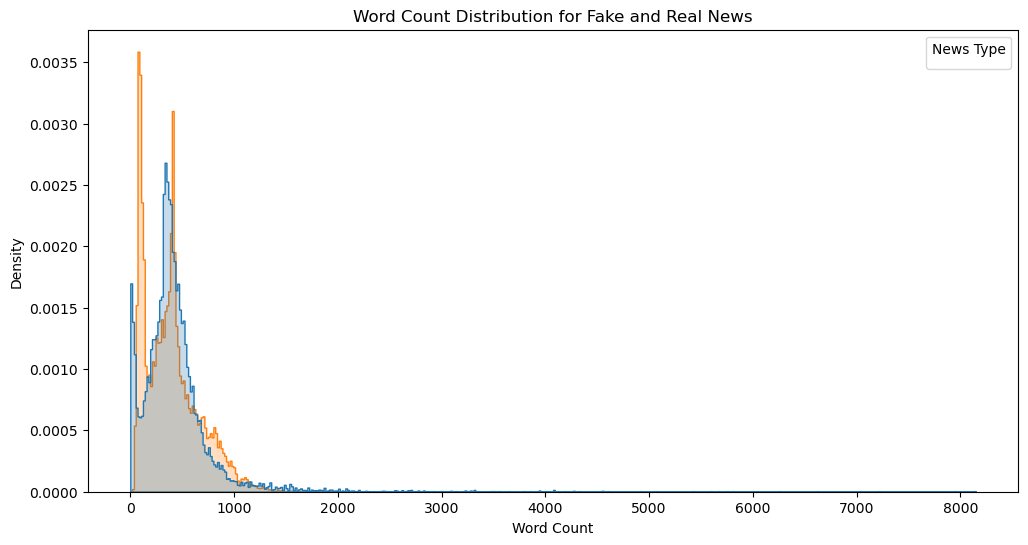

In [4]:
# Plotting word count between real and fake News

plt.figure(figsize=(12, 6))
sns.histplot(NewsData, x='word_count', hue='target', element='step', stat='density', common_norm=False)
plt.title('Word Count Distribution for Fake and Real News')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend(title='News Type')
plt.show()

## Exploring title length of real and fake news

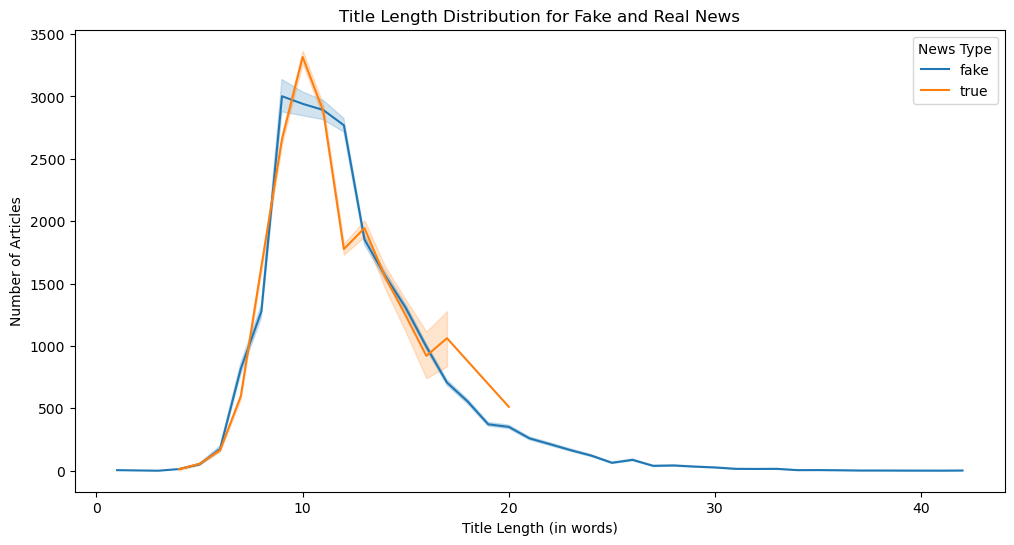

In [5]:
fakedf['title_length'] = fakedf['title'].apply(lambda x: len(str(x).split()))
truedf['title_length'] = truedf['title'].apply(lambda x: len(str(x).split()))

# Combine the dataframes for visualization

combined_df = pd.concat([fakedf, truedf])

# Sort by title length for a smoother line graph

combined_df = combined_df.sort_values(by="title_length").reset_index(drop=True)

# Plot Results

plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x='title_length', y=combined_df.groupby('title_length').cumcount(), hue='target')
plt.title('Title Length Distribution for Fake and Real News')
plt.xlabel('Title Length (in words)')
plt.ylabel('Number of Articles')
plt.legend(title='News Type')
plt.show()

## Exploring punctuation usage of real and fake news

In [6]:
# Extract Count Specfic Punctuation

def count_specific_punct(text, punct):
    return text.count(punct)

punctuation_list = ['.', ',', '?', '!', ':', ';']

for punct in punctuation_list:
    NewsData[punct] = NewsData['news'].apply(lambda x: count_specific_punct(x, punct))

# Calculate Mean Counts for Each Punctuation

mean_punctuation_counts = NewsData.groupby('target')[punctuation_list].mean().transpose()


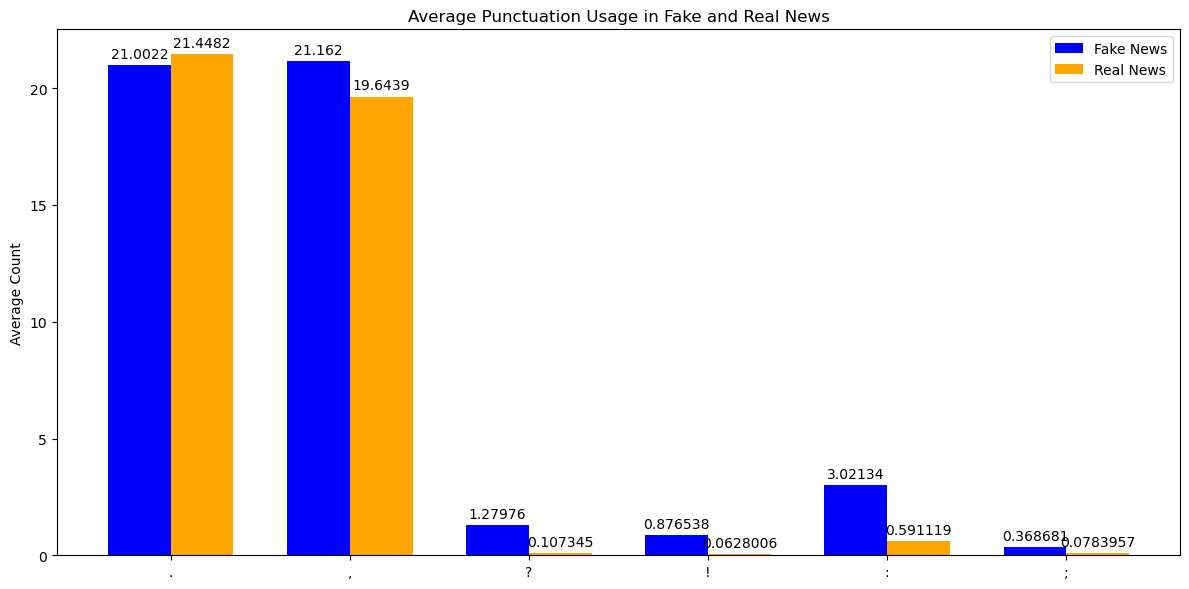

In [7]:
# Plot Results

labels = mean_punctuation_counts.index
fake_counts = mean_punctuation_counts['fake']
real_counts = mean_punctuation_counts['true']

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, fake_counts, width, label='Fake News', color='blue')
rects2 = ax.bar(x + width/2, real_counts, width, label='Real News', color='orange')

ax.set_ylabel('Average Count')
ax.set_title('Average Punctuation Usage in Fake and Real News')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()




## Explore Lexical Diversity

In [8]:
# Compute Lexical Diversity 

def lexical_diversity(text):
    words = text.split()
    if len(words) == 0:  # To prevent division by zero
        return 0
    return len(set(words)) / len(words)

NewsData['lexical_diversity'] = NewsData['news'].apply(lexical_diversity)

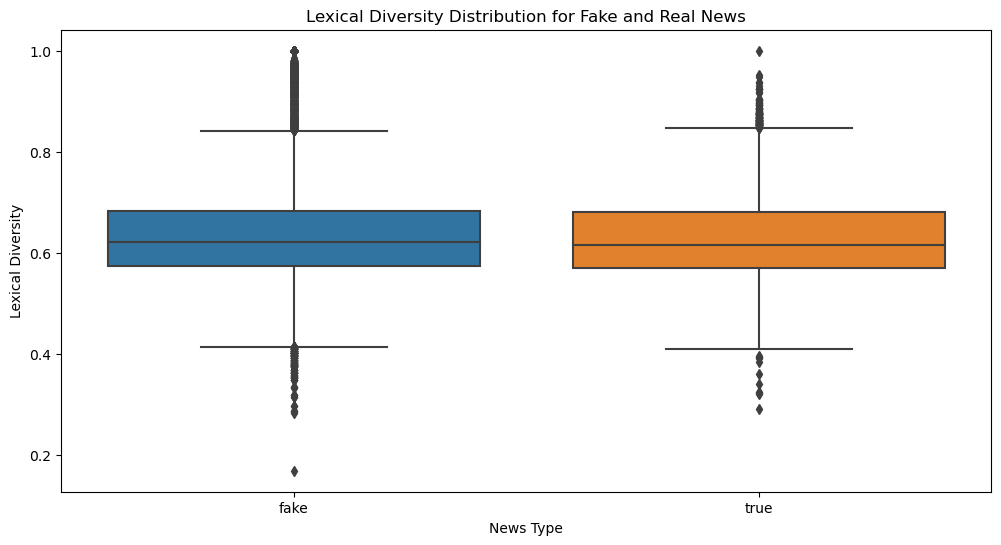

In [9]:
# Plot Results

plt.figure(figsize=(12, 6))
sns.boxplot(x='target', y='lexical_diversity', data=NewsData)
plt.title('Lexical Diversity Distribution for Fake and Real News')
plt.xlabel('News Type')
plt.ylabel('Lexical Diversity')
plt.show()

## Exploring Sentiment Analysis

In [10]:
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

In [11]:
NewsData['sentiment'] = NewsData['news'].apply(get_sentiment)


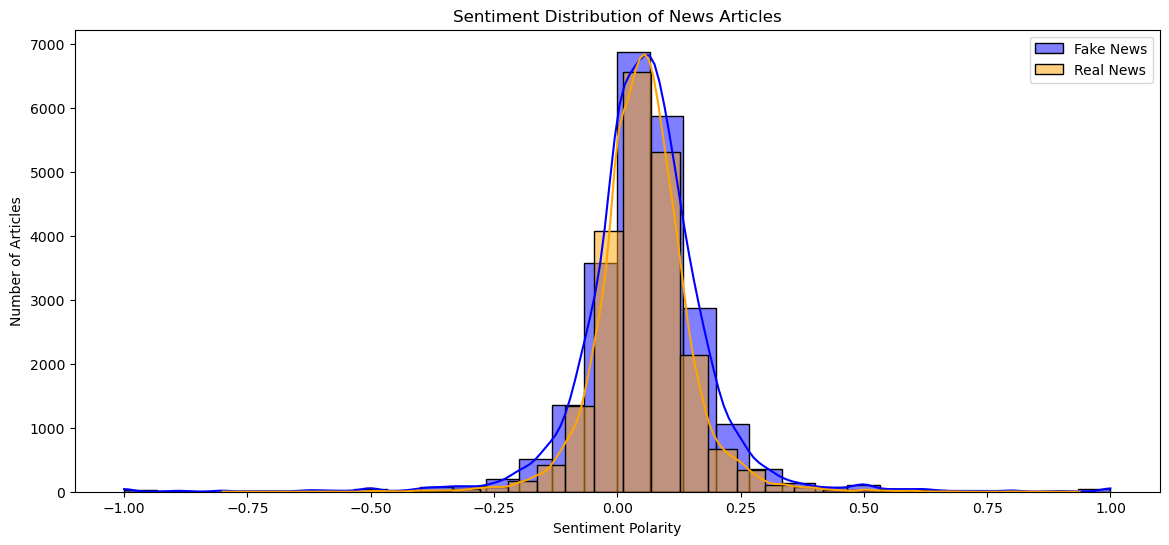

In [12]:
plt.figure(figsize=(14, 6))

# Plot sentiment for fake news
sns.histplot(NewsData[NewsData['target'] == 'fake']['sentiment'], color='blue', label='Fake News', bins=30, kde=True)

# Plot sentiment for real news
sns.histplot(NewsData[NewsData['target'] == 'true']['sentiment'], color='Orange', label='Real News', bins=30, kde=True)

plt.title('Sentiment Distribution of News Articles')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of Articles')
plt.legend()
plt.show()

## TOKENIZATION AND TEXT PREPROCESSING

In [13]:
port_S = PorterStemmer()
array_= []

for i in range(0, len(NewsData_Adjusted)):
      text_adj = re.sub('[^a-zA-Z]', ' ', NewsData_Adjusted['news'][i])
      text_adj = re.sub('https?://\S+|www\.\S+', '', NewsData_Adjusted['news'][i])
      text_adj = re.sub('<.*?>+', '', NewsData_Adjusted['news'][i])
      text_adj = re.sub('[%s]' % re.escape(string.punctuation), '', NewsData_Adjusted['news'][i])
      text_adj = re.sub('\n', '', NewsData_Adjusted['news'][i])
      text_adj = re.sub('\w*\d\w*', '', NewsData_Adjusted['news'][i])
      text_adj = text_adj.lower()
      text_adj = text_adj.split()
      text_adj = [port_S.stem(word) for word in text_adj if not word in stopwords.words('english')]
      text_adj = ' '.join(text_adj)
      array_.append(text_adj)



## BAG WORDS AND COUNT VECTORS

In [14]:
cv = CountVectorizer(max_features = 5000,ngram_range=(1,3))
X = cv.fit_transform(array_).toarray()
X.shape 
y =NewsData_Adjusted['target']

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4,random_state = 0)

In [16]:
count_df = pd.DataFrame(X_train,columns = cv.get_feature_names_out())

## Model Builder and Graph Results

In [17]:
def evaluate_classifier(classifier, X_train, y_train, X_test, y_test, heatmap_color='Blues'):
    # Record start time
    start_time = time.time()
    
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    
    # Record end time
    end_time = time.time()

    # Calculate runtime
    runtime = end_time - start_time

    # Evaluation of Results
    acc_score = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, zero_division=0, pos_label='true')
    precision = precision_score(y_test, pred, zero_division=0, pos_label='true')
    recall = recall_score(y_test, pred, zero_division=0, pos_label='true')
    
    percent_conv = acc_score * 100
    print("Accuracy: %0.2f%%" % percent_conv)
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Runtime:", runtime, "seconds")  # Print runtime
    
    cf_matrix = confusion_matrix(y_test, pred)
    sns.heatmap(cf_matrix, annot=True, cmap=heatmap_color)
    plt.show()



# MultinomialNB

Accuracy: 95.00%
F1 Score: 0.9523809523809524
Precision: 0.9433962264150944
Recall: 0.9615384615384616
Runtime: 0.05068826675415039 seconds


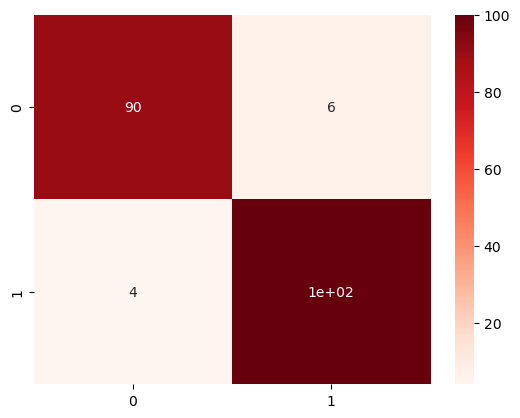

In [18]:
MultinomialNB_classifier = MultinomialNB()
evaluate_classifier(MultinomialNB_classifier, X_train, y_train, X_test, y_test, heatmap_color='Reds')

# kNN Classification

Accuracy: 68.00%
F1 Score: 0.6
Precision: 0.8571428571428571
Recall: 0.46153846153846156
Runtime: 0.03200578689575195 seconds


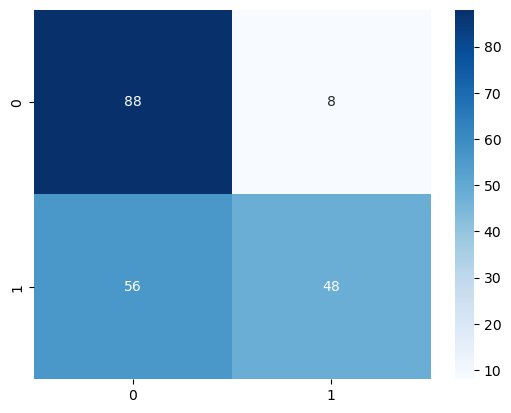

In [19]:
knn_classifier = KNeighborsClassifier()
evaluate_classifier(knn_classifier, X_train, y_train, X_test, y_test, heatmap_color='Blues')

# Logistic Regression 

Accuracy: 95.50%
F1 Score: 0.957345971563981
Precision: 0.9439252336448598
Recall: 0.9711538461538461
Runtime: 0.11060428619384766 seconds


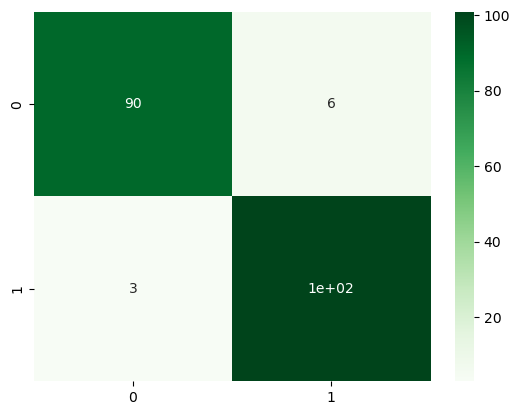

In [20]:
logreg_classifier = LogisticRegression()
evaluate_classifier(logreg_classifier, X_train, y_train, X_test, y_test, heatmap_color = "Greens")

# Random Forest Classifier

Accuracy: 96.50%
F1 Score: 0.966183574879227
Precision: 0.970873786407767
Recall: 0.9615384615384616
Runtime: 1.8203425407409668 seconds


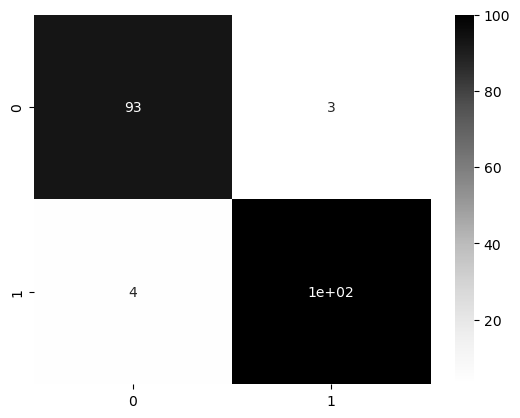

In [21]:
rfc = RandomForestClassifier(n_estimators = 600, bootstrap = True, random_state=8)
evaluate_classifier(rfc, X_train, y_train, X_test, y_test, heatmap_color = "Greys")

# Passive Agressive Classifier

Accuracy: 96.00%
F1 Score: 0.9619047619047619
Precision: 0.9528301886792453
Recall: 0.9711538461538461
Runtime: 0.05897712707519531 seconds


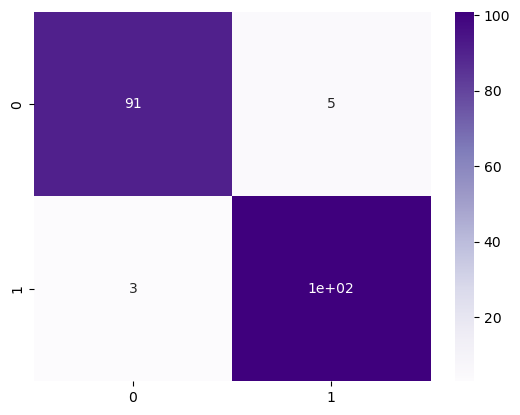

In [22]:
pac = PassiveAggressiveClassifier()
evaluate_classifier(pac, X_train, y_train, X_test, y_test, heatmap_color = "Purples")

## Models from Scratch

In [23]:
def evaluate_classifier_scratch(classifier, X_train, y_train, X_test, y_test, heatmap_color='Blues'):
    
    # Record start time
    start_time = time.time()
    
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    
     # Record end time
    end_time = time.time()

    # Calculate runtime
    runtime = end_time - start_time
    
    # Evaluation of Results
    acc_score = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, zero_division=0, pos_label=true_label)
    precision = precision_score(y_test, pred, zero_division=0, pos_label=true_label)
    recall = recall_score(y_test, pred, zero_division=0, pos_label=true_label)
    print("Runtime:", runtime, "seconds")  # Print runtime

    print(f"Acc: {acc_score * 100:.2f}%")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    cf_matrix = confusion_matrix(y_test, pred)
    sns.heatmap(cf_matrix, annot=True, cmap=heatmap_color)
    plt.show()
    

# MultinomialNB (from scratch)


In [24]:
class MultinomialNB:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        
    def fit(self, X, y):
        m, n = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
    
        # Create a mapping from class label to index
        self.class_to_index_ = {label: index for index, label in enumerate(self.classes_)}
    
        self.class_probs_ = np.zeros(n_classes)
        self.feature_probs_ = np.zeros((n_classes, n))

        # Class probabilities: P(y = c)
        for c in self.classes_:
            class_idx = self.class_to_index_[c]  # Use the mapping here
            self.class_probs_[class_idx] = np.sum(y == c) / m 

        # Conditional probabilities: P(x_i|y = c)
        for c in self.classes_:
            class_idx = self.class_to_index_[c]  # Use the mapping here
            X_c = X[y == c]
            self.feature_probs_[class_idx] = (X_c.sum(axis=0) + self.alpha) / (np.sum(X_c.sum(axis=0) + self.alpha))

        return self

    def predict(self, X):
        return [self._predict(x) for x in X]

    def _predict(self, x):
        posteriors = []

        # Calculate posterior probability for each class
        for idx, c in enumerate(self.classes_):
            prior = np.log(self.class_probs_[idx])
            cond_prob = sum(np.log(self.feature_probs_[idx][x == 1]))  # Use feature_probs_ here instead of cond_probs_
            posterior = prior + cond_prob
            posteriors.append(posterior)

        # Return class with highest posterior probability
        return self.classes_[np.argmax(posteriors)]


Accuracy: 95.00%
F1 Score: 0.9509803921568627
Precision: 0.97
Recall: 0.9326923076923077
Runtime: 0.03625297546386719 seconds


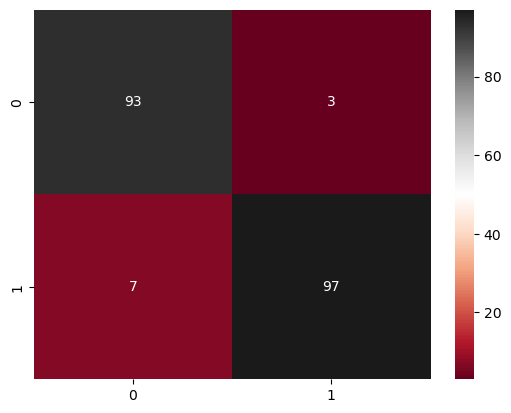

In [25]:
mnb_classifier = MultinomialNB(alpha=1.0)
evaluate_classifier(mnb_classifier, X_train, y_train, X_test, y_test, heatmap_color='RdGy')

# kNN Classification (from Scratch)

In [26]:
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = [np.sqrt(np.sum((x - x_train)**2)) for x_train in self.X_train]
        
        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]
        
        # Extract the labels of the k nearest neighbor training samples
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        # Return the most common class label
        most_common = np.bincount(k_nearest_labels).argmax()
        return most_common
 

Runtime: 0.8198566436767578 seconds
Acc: 70.00%
F1 Score: 0.6429
Precision: 0.8438
Recall: 0.5192


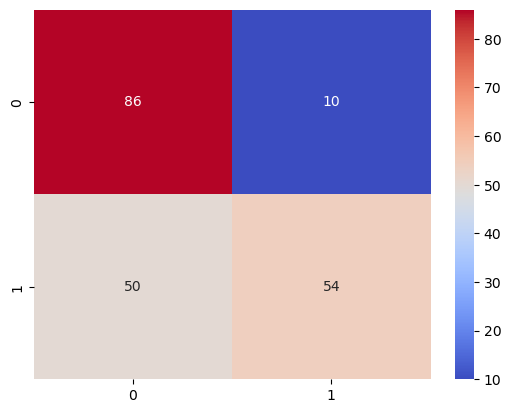

In [27]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
true_label = le.transform(['true'])[0]

knn_classifier = KNN(k=3)
evaluate_classifier_scratch(knn_classifier, X_train, y_train_encoded, X_test, y_test_encoded, heatmap_color='coolwarm')


# Logistic Regression (from Scratch)

In [28]:
class LogisticRegressionModel:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
        
    def predict_proba(self, X):
        linear = np.dot(X, self.weights) + self.bias
        return 1 / (1 + np.exp(-linear))
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)
    
    def fit(self, X, y):
        m = X.shape[0]
        y = y.values.reshape(-1, 1)  
        
        # Initialize weights and bias
        self.weights = np.zeros((X.shape[1], 1))
        self.bias = 0
        
        for i in range(self.num_iterations):
            predictions = self.predict_proba(X)
            
            dw = (1/m) * np.dot(X.T, (predictions - y))
            db = (1/m) * np.sum(predictions - y)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db


In [29]:
NewsData_Adjusted['target'] = NewsData_Adjusted['target'].replace({'fake': 0, 'true': 1})
NewsData_Adjusted['target'].head()
y =NewsData_Adjusted['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4,random_state = 0)


Runtime: 4.831061363220215 seconds
Acc: 95.50%
F1 Score: 0.9577
Precision: 0.9358
Recall: 0.9808


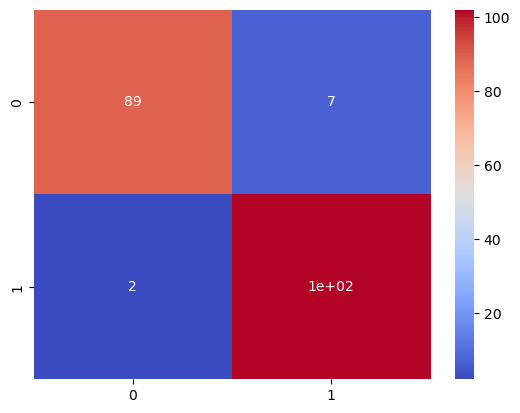

In [30]:
# Initialize the model
model = LogisticRegressionModel(learning_rate=0.01, num_iterations=1000)
evaluate_classifier_scratch(model, X_train, y_train, X_test, y_test, heatmap_color='coolwarm')



# Random Forest Classifier (from Scratch)

In [31]:
import numpy as np

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def _gini(self, y):
        m = len(y)
        return 1.0 - sum([(np.sum(y == c) / m) ** 2 for c in np.unique(y)])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        if depth == self.max_depth or n_classes == 1:
            return np.argmax(np.bincount(y))
        
        feature_idxs = np.random.choice(n_features, n_features, replace=False)
        best_gini = 1
        for feature_idx in feature_idxs:
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_idxs = X[:, feature_idx] < threshold
                right_idxs = X[:, feature_idx] >= threshold
                if sum(left_idxs) == 0 or sum(right_idxs) == 0:
                    continue
                gini_left = self._gini(y[left_idxs])
                gini_right = self._gini(y[right_idxs])
                gini = (gini_left * sum(left_idxs) + gini_right * sum(right_idxs)) / n_samples
                if gini < best_gini:
                    best_gini = gini
                    best_threshold = threshold
                    best_idx = feature_idx
                    best_left_idxs = left_idxs
                    best_right_idxs = right_idxs
        
        left_tree = self._grow_tree(X[best_left_idxs], y[best_left_idxs], depth + 1)
        right_tree = self._grow_tree(X[best_right_idxs], y[best_right_idxs], depth + 1)
        return (best_idx, best_threshold, left_tree, right_tree)

    def fit(self, X, y):
        self.tree_ = self._grow_tree(X, y)
        
    def _predict_sample(self, x, tree):
        if isinstance(tree, (int, np.integer)):
            return tree
        feature, threshold, left_tree, right_tree = tree
        if x[feature] < threshold:
            return self._predict_sample(x, left_tree)
        else:
            return self._predict_sample(x, right_tree)

    def predict(self, X):
        return [self._predict_sample(x, self.tree_) for x in X]


class RandomForestClassifier:
    def __init__(self, n_trees=100, max_depth=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        for _ in range(self.n_trees):
            idxs = np.random.choice(len(X), len(X), replace=True)
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X[idxs], y[idxs])
            self.trees.append(tree)

    def predict(self, X):
        X = np.array(X)
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.array([np.bincount(preds).argmax() for preds in predictions.T])


Runtime: 25.939666986465454 seconds
Acc: 98.00%
F1 Score: 0.9808
Precision: 0.9808
Recall: 0.9808


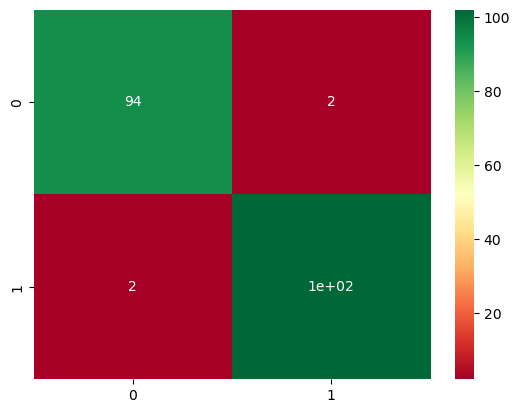

In [32]:
model = RandomForestClassifier(n_trees=10, max_depth=10)
evaluate_classifier_scratch(model, X_train, y_train, X_test, y_test, heatmap_color = "RdYlGn")


# Passive Agressive Classifier (from Scratch)

In [33]:
class PassiveAggressiveClassifier:
    def __init__(self, C=1.0, max_iter=1000, tol=1e-3):
        self.C = C
        self.max_iter = max_iter
        self.tol = tol
        self.w = None

    def fit(self, X, y):
        # Convert pandas structures to numpy arrays
        X = np.array(X)
        y = np.array(y)

        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)

        for _ in range(self.max_iter):
            for i in range(n_samples):
                f = np.dot(X[i], self.w)
                if y[i] * f < 1:
                    loss = max(0, 1 - y[i] * f)
                    tau = loss / (np.linalg.norm(X[i]) ** 2 + 1 / (2 * self.C))
                    self.w += tau * y[i] * X[i]

        return self

    def predict(self, X):
        # Convert pandas DataFrame to numpy array
        X = np.array(X)
        return np.sign(np.dot(X, self.w))


Runtime: 6.947141170501709 seconds
Acc: 52.00%
F1 Score: 0.6842
Precision: 0.5200
Recall: 1.0000


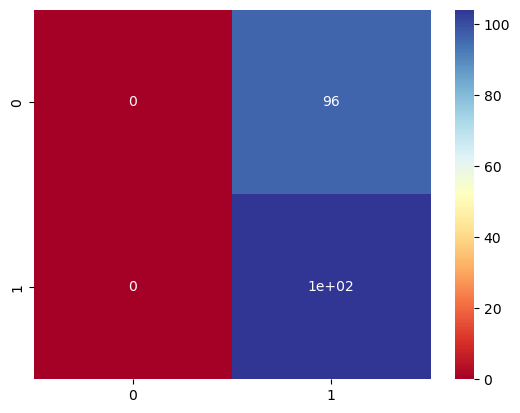

In [34]:
# Initialize and evaluate
model = PassiveAggressiveClassifier(C=1.0, max_iter=1000)
evaluate_classifier_scratch(model, X_train, y_train, X_test, y_test, heatmap_color = "RdYlBu")


# DEEPFAKE CLASSIFICATION

In [3]:
# Paths to videos
real_folder = './dataset/Deepfake/real/videos/'
deepfake_folder = './dataset/Deepfake/fake/Deepfakes/videos/'

real_videos = [os.path.join(real_folder, video) for video in os.listdir(real_folder) if video.endswith('.mp4')]
deepfake_videos = [os.path.join(deepfake_folder, video) for video in os.listdir(deepfake_folder) if video.endswith('.mp4')]

# Combine the video paths
video_paths = real_videos + deepfake_videos

# Generate labels (0 for real, 1 for deepfake)
labels = [0]*len(real_videos) + [1]*len(deepfake_videos)


In [4]:
# Initialize MTCNN and InceptionResnetV1
mtcnn = MTCNN(keep_all=True)
model = InceptionResnetV1(pretrained='vggface2').eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mtcnn = mtcnn.to(device)
model = model.to(device)

In [ ]:
def extract_features(video_path, skip_frames=50):  # Default: process every 50th frame
    cap = cv2.VideoCapture(video_path)
    embeddings = []

    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        if frame_count % skip_frames != 0:
            continue  # Skip this frame

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        face_tensors = mtcnn(frame)
        
        if face_tensors is not None:  
            if len(face_tensors.shape) == 3:
                face_tensors = face_tensors.unsqueeze(0)
            face_tensors = face_tensors.to(device)  
            embedding = model(face_tensors)
            embeddings.append(embedding.detach().cpu().numpy())
    
    cap.release()

    if embeddings:
        return np.mean(np.vstack(embeddings), axis=0)
    else:
        return None


features = []
new_labels = []

for video, label in zip(video_paths, labels):
    feature = extract_features(video)
    if feature is not None:
        features.append(feature)
        new_labels.append(label)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, new_labels, test_size=0.2)

In [7]:
clf = SVC()
clf.fit(X_train, y_train)

SVC()

In [8]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 68.25%


# REFERENCES

## [1] Bisaillon, C. (n.d.). Fake and Real News Dataset. Retrieved May 7, 2023, from https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

## [2] Ondyari. (n.d.). Ondyari/faceforensics: Github of the faceforensics dataset. GitHub. https://github.com/ondyari/FaceForensics 
